In [2]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib import Path


In [2]:
incidents = pd.read_csv('unique_fires.csv')
incidents = incidents[incidents['Fire Name']=='AUGUST COMPLEX'] #here we filter out August Complex
incidents # these are submitted in local time

inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
incidents

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire
1088,11843929.0,AUGUST COMPLEX,2020-08-17 13:44:00,2020-11-11,39.659444,-122.808889


In [3]:
#viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})
viirs_all = pd.read_csv('/data2/lthapa/fire_archive_M-C61_221506.csv')#THIS IS MODIS, I JUST KEPT THE NAME SINCE IT'S USED EVERYWHERE
viirs_all

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,36.1292,-114.9293,304.2,1.2,1.1,2019-01-01,950,Aqua,MODIS,59,6.03,271.1,14.1,N,0
1,32.6579,-115.0683,325.9,1.0,1.0,2019-01-01,2052,Aqua,MODIS,84,6.03,290.1,22.8,D,0
2,32.6563,-115.0788,339.1,1.0,1.0,2019-01-01,2052,Aqua,MODIS,91,6.03,291.2,40.8,D,0
3,34.0070,-117.3790,304.5,1.1,1.1,2019-01-01,2053,Aqua,MODIS,59,6.03,288.6,6.5,D,2
4,39.5338,-118.5765,307.1,1.1,1.0,2019-01-01,2054,Aqua,MODIS,56,6.03,276.8,11.6,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118508,39.7513,-122.3066,322.3,1.2,1.1,2020-12-31,2131,Aqua,MODIS,82,6.03,287.0,26.8,D,0
118509,39.7121,-122.2936,300.4,1.2,1.1,2020-12-31,2131,Aqua,MODIS,35,6.03,286.2,5.6,D,0
118510,38.7099,-122.8631,316.1,1.1,1.1,2020-12-31,2131,Aqua,MODIS,76,6.03,285.8,18.6,D,0
118511,37.7988,-121.1489,301.3,1.3,1.1,2020-12-31,2131,Aqua,MODIS,46,6.03,281.4,8.6,D,0


In [4]:
#get the size of the resulting dataframe
df_size = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
print(df_size)

1920


In [17]:
fire_series = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of MODIS points': np.nan*np.zeros(df_size), 
                                'FRP': np.nan*np.zeros(df_size),
            'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
count = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    lat_fire = incidents.iloc[ii]['Lat Fire']
    lon_fire = incidents.iloc[ii]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    poly_lats = np.array([lat_fire])
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
   
    for day in dates: #loop over the days
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        for over in overpasses: #loop over the overpasses
            print(day, over)
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
            
            
            mp, poly_lats, poly_lons = build_today_polygon(pt_start, lat, lon, lat_old, lon_old, 0.3, 0)
            
            num_viirs = len(poly_lats)
            print(num_viirs, 'VIIRS detections')
            if num_viirs==0: #if no points, persist the previous polygon
                poly = pt_start
                poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
            elif (num_viirs<=0.1*len(lat_old))|(num_viirs<=2): #if points drop off by >90% or to 2 or fewer
                #use old polygon, and ADD THE NEW POINTS, just in case
                lat_old = np.append(lat_old, poly_lats)
                lon_old = np.append(lon_old, poly_lons)
                poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
                poly = MultiPoint(poly_tups).convex_hull
                
            else: #make a new polygon 
                #print('HELLO!')
                old_poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))] #old polygon points
                poly_tups = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lats))] #new polygon points
                poly_tups = [item for item in poly_tups if item not in old_poly_tups] #get rid of duplicates                
                poly = MultiPoint(poly_tups).convex_hull
            
            
            inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups] #inds where we grab FRP
            if len(inds_new_points)==0:
                frp=np.nan
            else:
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
            fire_series.iloc[count] = [incidents['Incident Number'].iloc[ii],\
                                       incidents['Fire Name'].iloc[ii],\
                                       day, over, lat_fire, lon_fire, num_viirs,\
                                      frp, poly]
            lat_old = [poly_tups[i][1] for i in range(len(poly_tups))]
            lon_old = [poly_tups[i][0] for i in range(len(poly_tups))]
            pt_start=poly
            count = count+1
                
            
fire_series

-122.8088889 39.6594444
2020-08-18 427
0 VIIRS detections
2020-08-18 429
0 VIIRS detections
2020-08-18 430
0 VIIRS detections
2020-08-18 431
0 VIIRS detections
2020-08-18 605
0 VIIRS detections
2020-08-18 606
0 VIIRS detections
2020-08-18 607
0 VIIRS detections
2020-08-18 608
0 VIIRS detections
2020-08-18 609
0 VIIRS detections
2020-08-18 840
0 VIIRS detections
2020-08-18 842
0 VIIRS detections
2020-08-18 844
0 VIIRS detections
2020-08-18 1018
0 VIIRS detections
2020-08-18 1805
0 VIIRS detections
2020-08-18 1806
0 VIIRS detections
2020-08-18 1807
0 VIIRS detections
2020-08-18 1808
0 VIIRS detections
2020-08-18 1809
0 VIIRS detections
2020-08-18 1943
0 VIIRS detections
2020-08-18 1944
0 VIIRS detections
2020-08-18 1945
Time for recursive call
6 VIIRS detections
2020-08-18 1946
0 VIIRS detections
2020-08-18 1947
0 VIIRS detections
2020-08-18 1948
0 VIIRS detections
2020-08-18 1949
0 VIIRS detections
2020-08-19 509
0 VIIRS detections
2020-08-19 510
0 VIIRS detections
2020-08-19 511
0 VIIR

2020-08-28 1056
0 VIIRS detections
2020-08-28 1706
0 VIIRS detections
2020-08-28 1841
0 VIIRS detections
2020-08-28 1842
0 VIIRS detections
2020-08-28 1843
0 VIIRS detections
2020-08-28 1844
Time for recursive call
Time for recursive call
56 VIIRS detections
2020-08-28 1845
0 VIIRS detections
2020-08-28 1846
0 VIIRS detections
2020-08-28 2022
0 VIIRS detections
2020-08-28 2023
0 VIIRS detections
2020-08-28 2024
14 VIIRS detections
2020-08-28 2025
0 VIIRS detections
2020-08-28 2026
0 VIIRS detections
2020-08-28 2201
0 VIIRS detections
2020-08-28 2202
Time for recursive call
18 VIIRS detections
2020-08-28 2203
0 VIIRS detections
2020-08-28 2204
0 VIIRS detections
2020-08-29 547
0 VIIRS detections
2020-08-29 548
0 VIIRS detections
2020-08-29 549
Time for recursive call
109 VIIRS detections
2020-08-29 550
0 VIIRS detections
2020-08-29 551
0 VIIRS detections
2020-08-29 959
0 VIIRS detections
2020-08-29 1000
0 VIIRS detections
2020-08-29 1001
0 VIIRS detections
2020-08-29 1002
Time for recur

0 VIIRS detections
2020-09-06 2156
53 VIIRS detections
2020-09-06 2157
0 VIIRS detections
2020-09-07 541
0 VIIRS detections
2020-09-07 542
0 VIIRS detections
2020-09-07 543
Time for recursive call
101 VIIRS detections
2020-09-07 544
0 VIIRS detections
2020-09-07 545
0 VIIRS detections
2020-09-07 817
0 VIIRS detections
2020-09-07 953
0 VIIRS detections
2020-09-07 954
0 VIIRS detections
2020-09-07 955
0 VIIRS detections
2020-09-07 956
Time for recursive call
117 VIIRS detections
2020-09-07 957
0 VIIRS detections
2020-09-07 958
0 VIIRS detections
2020-09-07 1742
0 VIIRS detections
2020-09-07 1743
0 VIIRS detections
2020-09-07 1744
0 VIIRS detections
2020-09-07 1918
0 VIIRS detections
2020-09-07 1919
0 VIIRS detections
2020-09-07 1920
0 VIIRS detections
2020-09-07 1921
Time for recursive call
130 VIIRS detections
2020-09-07 1922
0 VIIRS detections
2020-09-07 1923
0 VIIRS detections
2020-09-07 2058
0 VIIRS detections
2020-09-07 2059
0 VIIRS detections
2020-09-07 2100
0 VIIRS detections
2020

2020-09-15 453
0 VIIRS detections
2020-09-15 454
0 VIIRS detections
2020-09-15 455
0 VIIRS detections
2020-09-15 630
0 VIIRS detections
2020-09-15 631
0 VIIRS detections
2020-09-15 632
87 VIIRS detections
2020-09-15 633
0 VIIRS detections
2020-09-15 905
0 VIIRS detections
2020-09-15 906
0 VIIRS detections
2020-09-15 907
0 VIIRS detections
2020-09-15 908
0 VIIRS detections
2020-09-15 1043
0 VIIRS detections
2020-09-15 1044
0 VIIRS detections
2020-09-15 1045
62 VIIRS detections
2020-09-15 1829
0 VIIRS detections
2020-09-15 1830
0 VIIRS detections
2020-09-15 1831
0 VIIRS detections
2020-09-15 1832
Time for recursive call
70 VIIRS detections
2020-09-15 1833
0 VIIRS detections
2020-09-15 2009
0 VIIRS detections
2020-09-15 2010
0 VIIRS detections
2020-09-15 2011
0 VIIRS detections
2020-09-15 2012
0 VIIRS detections
2020-09-15 2013
0 VIIRS detections
2020-09-15 2014
0 VIIRS detections
2020-09-15 2148
0 VIIRS detections
2020-09-15 2149
0 VIIRS detections
2020-09-15 2150
Time for recursive call

2020-09-25 945
0 VIIRS detections
2020-09-25 946
0 VIIRS detections
2020-09-25 1727
0 VIIRS detections
2020-09-25 1730
0 VIIRS detections
2020-09-25 1732
0 VIIRS detections
2020-09-25 1908
Time for recursive call
Time for recursive call
20 VIIRS detections
2020-09-25 1909
0 VIIRS detections
2020-09-25 1910
0 VIIRS detections
2020-09-25 2046
0 VIIRS detections
2020-09-25 2047
0 VIIRS detections
2020-09-25 2048
0 VIIRS detections
2020-09-25 2049
13 VIIRS detections
2020-09-25 2050
0 VIIRS detections
2020-09-26 435
0 VIIRS detections
2020-09-26 611
0 VIIRS detections
2020-09-26 612
0 VIIRS detections
2020-09-26 613
6 VIIRS detections
2020-09-26 847
0 VIIRS detections
2020-09-26 848
0 VIIRS detections
2020-09-26 850
0 VIIRS detections
2020-09-26 1026
Time for recursive call
Time for recursive call
Time for recursive call
12 VIIRS detections
2020-09-26 1027
0 VIIRS detections
2020-09-26 1812
0 VIIRS detections
2020-09-26 1813
0 VIIRS detections
2020-09-26 1815
0 VIIRS detections
2020-09-26 

0 VIIRS detections
2020-10-05 1808
0 VIIRS detections
2020-10-05 1809
0 VIIRS detections
2020-10-05 1943
0 VIIRS detections
2020-10-05 1944
0 VIIRS detections
2020-10-05 1945
12 VIIRS detections
2020-10-05 1947
0 VIIRS detections
2020-10-05 1948
0 VIIRS detections
2020-10-05 1949
0 VIIRS detections
2020-10-05 2123
0 VIIRS detections
2020-10-05 2124
0 VIIRS detections
2020-10-05 2125
Time for recursive call
53 VIIRS detections
2020-10-05 2126
0 VIIRS detections
2020-10-05 2127
0 VIIRS detections
2020-10-06 509
0 VIIRS detections
2020-10-06 510
0 VIIRS detections
2020-10-06 511
0 VIIRS detections
2020-10-06 512
0 VIIRS detections
2020-10-06 514
0 VIIRS detections
2020-10-06 649
0 VIIRS detections
2020-10-06 650
16 VIIRS detections
2020-10-06 651
0 VIIRS detections
2020-10-06 923
0 VIIRS detections
2020-10-06 924
0 VIIRS detections
2020-10-06 925
3 VIIRS detections
2020-10-06 926
0 VIIRS detections
2020-10-06 1103
3 VIIRS detections
2020-10-06 1711
0 VIIRS detections
2020-10-06 1848
0 VII

0 VIIRS detections
2020-10-16 2107
Time for recursive call
6 VIIRS detections
2020-10-16 2108
0 VIIRS detections
2020-10-16 2109
0 VIIRS detections
2020-10-17 452
0 VIIRS detections
2020-10-17 453
0 VIIRS detections
2020-10-17 630
0 VIIRS detections
2020-10-17 631
0 VIIRS detections
2020-10-17 633
0 VIIRS detections
2020-10-17 906
0 VIIRS detections
2020-10-17 907
0 VIIRS detections
2020-10-17 908
0 VIIRS detections
2020-10-17 1045
0 VIIRS detections
2020-10-17 1830
0 VIIRS detections
2020-10-17 1831
0 VIIRS detections
2020-10-17 1832
0 VIIRS detections
2020-10-17 1833
0 VIIRS detections
2020-10-17 2009
0 VIIRS detections
2020-10-17 2010
0 VIIRS detections
2020-10-17 2011
0 VIIRS detections
2020-10-17 2012
0 VIIRS detections
2020-10-17 2013
0 VIIRS detections
2020-10-17 2149
0 VIIRS detections
2020-10-17 2150
3 VIIRS detections
2020-10-17 2151
0 VIIRS detections
2020-10-18 534
0 VIIRS detections
2020-10-18 535
0 VIIRS detections
2020-10-18 536
0 VIIRS detections
2020-10-18 949
0 VIIRS 

2020-10-31 2022
0 VIIRS detections
2020-10-31 2023
0 VIIRS detections
2020-10-31 2024
0 VIIRS detections
2020-10-31 2025
0 VIIRS detections
2020-10-31 2026
0 VIIRS detections
2020-11-01 547
0 VIIRS detections
2020-11-01 548
0 VIIRS detections
2020-11-01 549
0 VIIRS detections
2020-11-01 1002
0 VIIRS detections
2020-11-01 1749
0 VIIRS detections
2020-11-01 1750
0 VIIRS detections
2020-11-01 1924
0 VIIRS detections
2020-11-01 1925
0 VIIRS detections
2020-11-01 1926
0 VIIRS detections
2020-11-01 1927
0 VIIRS detections
2020-11-01 1930
0 VIIRS detections
2020-11-01 2104
0 VIIRS detections
2020-11-01 2106
0 VIIRS detections
2020-11-01 2107
0 VIIRS detections
2020-11-01 2108
0 VIIRS detections
2020-11-01 2109
0 VIIRS detections
2020-11-02 451
0 VIIRS detections
2020-11-02 631
0 VIIRS detections
2020-11-02 1828
0 VIIRS detections
2020-11-02 1829
0 VIIRS detections
2020-11-02 1830
0 VIIRS detections
2020-11-02 1832
0 VIIRS detections
2020-11-02 1833
0 VIIRS detections
2020-11-02 1836
0 VIIRS d

,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of MODIS points,FRP,geometry
0,11843929.0,AUGUST COMPLEX,2020-08-18,427.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
1,11843929.0,AUGUST COMPLEX,2020-08-18,429.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
2,11843929.0,AUGUST COMPLEX,2020-08-18,430.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
3,11843929.0,AUGUST COMPLEX,2020-08-18,431.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
4,11843929.0,AUGUST COMPLEX,2020-08-18,605.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
...,...,...,...,...,...,...,...,...,...
1915,11843929.0,AUGUST COMPLEX,2020-11-11,2004.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."
1916,11843929.0,AUGUST COMPLEX,2020-11-11,2142.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."
1917,11843929.0,AUGUST COMPLEX,2020-11-11,2143.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."
1918,11843929.0,AUGUST COMPLEX,2020-11-11,2144.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.11670 40.24470, -123.09930 40.2..."


In [19]:
hi = fire_series['geometry']
hi
therest = fire_series[['Incident Number', 'Fire Name', 'Current Day','Current Overpass','Lat Fire', 'Lon Fire','Number of MODIS points', 'FRP']]
therest

fiona.supported_drivers
hi.to_file("august_complex_polygons_only_MODIS.geojson", driver='GeoJSON')
therest.to_csv('august_complex_polygons_attributes_MODIS.csv')

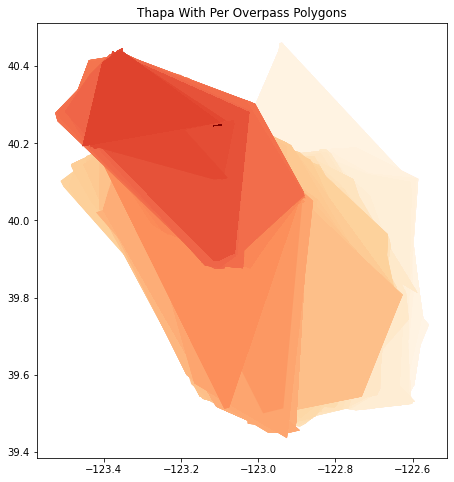

In [18]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
fire_series.plot(column = fire_series['Current Day'], ax=ax, cmap='OrRd')
plt.title('Thapa With Per Overpass Polygons')
plt.show()

In [6]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(shape, lats, lons, lat_old, lon_old, bf, plot_evol):
    shape_buff = shape.buffer(bf)
    
    #find the points that are inside the buffer
    lat_new = np.nan*np.zeros(len(lats))
    lon_new = np.nan*np.zeros(len(lons))
    i = 0
    for pair in zip(lons, lats):
        pt_check = Point(pair)
        if shape_buff.contains(pt_check):
            #add the point to the list
            lat_new[i] = pair[1]
            lon_new[i] = pair[0]
            i = i+1
    #grab the new points
    lat_new = lat_new[np.where(~np.isnan(lat_new))]
    lon_new = lon_new[np.where(~np.isnan(lon_new))]
    #make a shape around them
    tups = [list((lon_new[i], lat_new[i])) for i in range(len(lat_new))]
    mp = MultiPoint(tups).convex_hull
    
    if plot_evol == 1: #plot the new polygon
        print(len(lat_new), len(lon_new))
        m = gpd.GeoSeries(mp)
        m.plot()
        plt.scatter(lon_new, lat_new, c = 'k')
        plt.scatter(lon_fire, lat_fire, c='r')
        plt.title('Updated shape and points')
        plt.show()
    
    if (len(lat_new)-len(lat_old))>0: #if we are adding points
        print('Time for recursive call')
        return build_today_polygon(mp, lats, lons, lat_new, lon_new, bf, plot_evol)
    else:
        return mp, lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON

In [3]:
tupVerts=[(86, 52), (85, 52), (81, 53), (80, 52), (79, 48), (81, 49), (86, 53),
 (85, 51), (82, 54), (84, 54), (83, 49), (81, 52), (80, 50), (81, 48),
 (85, 50), (86, 54), (85, 54), (80, 48), (79, 50), (85, 49), (80, 51),
 (85, 53), (82, 49), (83, 54), (82, 53), (84, 49), (79, 49)]


x, y = np.meshgrid(np.arange(300), np.arange(300)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 

p = Path(tupVerts) # make a polygon
grid = p.contains_points(points)
mask = grid.reshape(300,300)
print(mask)

TypeError: expected str, bytes or os.PathLike object, not list